## In this notebook, I will leverage Random Forest and Xgboost to create the classifier
## Consider the data is imbalanced, I also perform analysis on the  ROC curve and precision recall curve
## I search the best threshold based on the analysis, the metrics I focus is recall, F1 and AUC. 
## The result from RF and Xgboost is close but not good, I decide to use an End-to-End ensemble method designed by myself to mix all ensemble models together.
## In the next notebook, I use the End-to-End method! 

## 1. RandomForest

In [1]:
import pickle
with open('data.pickle','rb') as load:
    data=pickle.load(load)
with open('x_train_le.pickle','rb') as load:
    x_train_le=pickle.load(load)
with open('y.pickle','rb') as load:
    y=pickle.load(load)
with open('train_test_index.pickle','rb') as load:
    train_test_index=pickle.load(load)
with open('feature_final.pickle','rb') as load:
    feature_final=pickle.load(load)
y_train=y[train_test_index['y_train']]

In [2]:
##Hyper_parameters tuning
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

### I use random search to find the best model, since we only have 4 hours to do this task and it is time consuming for searching best model, so I only set up n_iter = 1, the bigger this value is the better solution will be found
### Also, notice that metric here for searching best model is AUC

In [3]:
from time import time
from sklearn.ensemble import RandomForestClassifier
start=time()
# Use the   random grid to search for best hyperparameters
rf = RandomForestClassifier(class_weight='balanced')
rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=1, random_state=42, n_jobs = -1,scoring='roc_auc')
# Fit the random search model
rs.fit(x_train_le,y_train)
print(time()-start)    

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


269.09614872932434


In [4]:
print(rs.best_estimator_)
print(rs.best_score_)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
0.7962098939950699


In [5]:
par=rs.best_params_
rf_best=RandomForestClassifier(n_estimators=par['n_estimators'],
                               min_samples_split=par['min_samples_split'],
                               min_samples_leaf=par['min_samples_leaf'],
                              max_features=par['max_features'],
                              max_depth=par['max_depth'],
                              bootstrap=par['bootstrap'],
                              class_weight='balanced',
                              random_state=0)

## Since I have generated the best model by random search, let's train the model and check the performace on the validation set. Also, I need to use validation set to determine best threshold

In [6]:
from sklearn.model_selection import train_test_split
x_train_train,x_valid,y_train_train,y_valid=train_test_split(x_train_le,y_train,
                                               test_size=0.2,
                                               random_state=123,
                                               stratify=y_train)
rf_best.fit(x_train_train,y_train_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [7]:
dict_feat_import=dict(zip(feature_final,rf_best.feature_importances_))
dict_feat_import=dict(sorted(dict_feat_import.items(), key=lambda x: x[1],reverse=True))

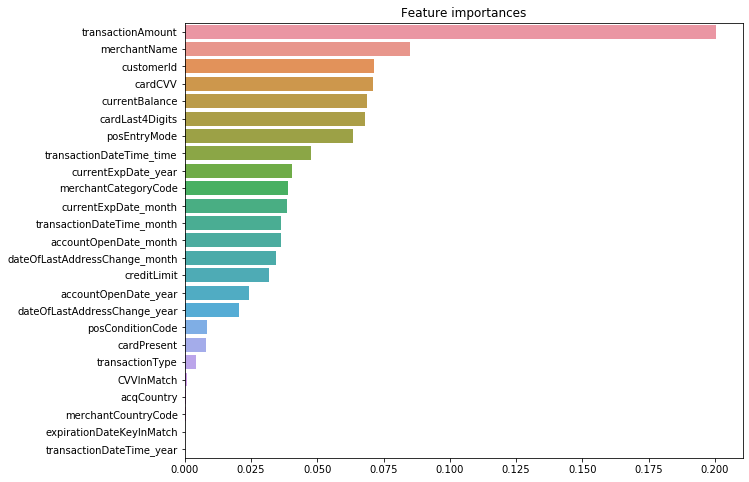

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
x_bar=dict_feat_import.keys()
y_bar=dict_feat_import.values()
plt.figure(figsize=(10,8))
plt.title("Feature importances")
sns.barplot(list(y_bar),list(x_bar))
plt.show()

### The most important feature is transaction amount!

## 2. ROC_Curve & Precision_Recall_Curve Analysis
### AUC value is a good way to measue classifier prediction performace on the  imbalanced datset.  I use AUC to select the best model, now I will use ROC curve and precision recall curve to find the best threshold for the classifier! For fraud transaction issue, the cost of leaving a true fraud transaction is much bigger than wrong freeze a normal transaction. Since, a wrong frozen can be corrected when that customer call back to argue. But failed to predict a true fraud transaction may cause big loss. Therefore, I select recall as the most important metric here. Usually, a higer recall will cause a lower precision as showed on precision recall curve, but too many false positive cases are also not acceptable. Therefore, my strategy is choosing the best threshold by keeping recall in a high level range and find the highest precision. I will check both ROC and precision recall curve.  

In [9]:
y_valid_predict_prob=rf_best.predict_proba(x_valid)[:,1]
y_valid_predict_prob

array([0.25246321, 0.02305417, 0.14671391, ..., 0.09464541, 0.19707389,
       0.05398478])

In [10]:
###ROC-AUC###
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,thresholds=roc_curve(y_valid.values,y_valid_predict_prob)
auc=roc_auc_score(y_valid.values,y_valid_predict_prob)
print(thresholds)
print('The AUC area value under the ROC curve is',auc)

[1.98173592e+00 9.81735922e-01 8.51353553e-01 ... 7.61345767e-04
 7.41118478e-04 0.00000000e+00]
The AUC area value under the ROC curve is 0.8054019694802135


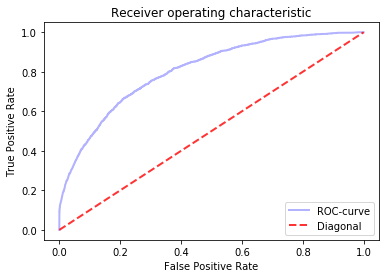

In [11]:
##ROC_curve based on traing data
plt.plot(fpr, tpr, lw=2, alpha=0.3,color='b',label='ROC-curve')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Diagonal', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
##Chose the best threshold! 
##Default threshold is 0.5, let's see which alternative is the best
print('true positive rate:',tpr[np.argmax(tpr-fpr)])
print('false positive rate:', fpr[np.argmax(tpr-fpr)])
print('The best threshold based on ROC is:', thresholds[np.argmax(tpr-fpr)])

true positive rate: 0.7018805309734514
false positive rate: 0.24764368328724765
The best threshold based on ROC is: 0.18806708103843015


### If we take the max(tpr-fpr) as the best point of threshold, which is a very popular strategy to determine the threshold. This strategy is just selecting the most left up corner point in the curve! However, the most important metrics for transaction fraud is recall!
### Let's see the precision recall curve!

Average precision-recall score: 0.19


Text(0.5, 1.0, 'Precision-Recall curve: AP=0.19')

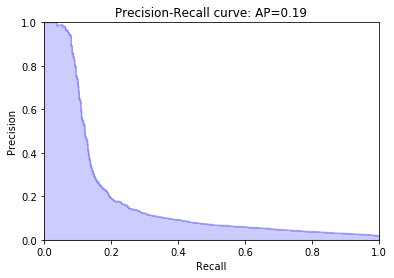

In [13]:
from sklearn.metrics import precision_recall_curve
##precision_recall_curve##
precision,recall,thre=precision_recall_curve(y_valid.values,y_valid_predict_prob)
##gene-curve
from inspect import signature
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_valid.values,y_valid_predict_prob)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## The precision recall curve is not so good, let's find the best threshold based on it!

## In order to get a recall bigger than 60% and precision will be around 5%, then we have to set up the threshold = 0.24! and the F1 score is around 10%.

In [14]:
import pandas as pd
thre_df=pd.DataFrame({'precision':precision,'recall':recall,'F1': 2*(precision*recall)/(precision+recall),'threshold':np.append(thre,thre[-1])})

In [15]:
thre_df[(thre_df['precision']>0.05) & (thre_df['recall']>0.6)]

,precision,recall,F1,threshold
70263,0.050002,0.683075,0.093183,0.196375
70264,0.050004,0.683075,0.093186,0.196375
70265,0.050006,0.683075,0.093190,0.196385
70266,0.050008,0.683075,0.093193,0.196386
70267,0.050010,0.683075,0.093197,0.196387
70268,0.050012,0.683075,0.093201,0.196391
70269,0.050014,0.683075,0.093204,0.196405
70270,0.050016,0.683075,0.093208,0.196411
70271,0.050018,0.683075,0.093211,0.196414
70272,0.050020,0.683075,0.093215,0.196428


## My suggesting is in order gerantee the recall for our model. We need to set up threshold as 0.24！which F1 is 0.1
## Really bad result! But I do not have more time to search better model by gridserach. 

## Testing the Performace!

In [16]:
#check the performance in testing data set!
x_test=data.iloc[train_test_index['x_test'],:]
y_test=y[train_test_index['y_test']]

categorical_features=feature_final[:22]
interval_features=feature_final[22:]
with open('le.pickle','rb') as load:
    le=pickle.load(load)

x_test_le=le.transform(x_test[categorical_features])
x_test_le=np.append(x_test_le,x_test[interval_features],axis=1)

##predict testing data
y_test_predict_prob=rf_best.predict_proba(x_test_le)[:,1]

In [17]:
y_test_predict=(y_test_predict_prob>0.16)

In [18]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
print(confusion_matrix(y_test.values,y_test_predict))
print('Precision:',precision_score(y_test.values,y_test_predict))
print('Recall:',recall_score(y_test.values,y_test_predict))
print('F1-score:',f1_score(y_test.values,y_test_predict))

[[87839 38284]
 [  580  1680]]
Precision: 0.04203783405064558
Recall: 0.7433628318584071
F1-score: 0.07957559681697612


## RF is  bagging ensemble not like boosting ensemble can improve the bais, RF can only reduce the variance. So I want to try Xgboost to see if metrics can be better!
## 3. XGB

In [8]:
import pickle 
with open('x_train_le.pickle','rb') as load:
    x_train_le=pickle.load(load)
with open('y.pickle','rb') as load:
    y=pickle.load(load)
with open('train_test_index.pickle','rb') as load:
    train_test_index=pickle.load(load)
y_train=y[train_test_index['y_train']]

## Since I do not have much time to truely conduct randomsearch for xgb as RF. So I just random search one model 

In [11]:
from time import time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
start=time()
param_grid = {
    'eta':[0.01,0.015,0.025,0.05,0.1],
    'gamma':[0.05,0.07,0.1,0.3,0.5,0.7,0.9,1],
    'max_depth':[5,8,15,20], 
    'min_child_weight':[1,3,5,7],
    "subsample":[0.6,0.7,0.8,0.9,1],
    "colsample_bytree":[0.6,0.7,0.8,0.9,1],
    'reg_lambda':[0.01,0.015,0.025,0.05,0.1,1],
    'reg_alpha':[0,0.1,0.5,1] }

xgb = XGBClassifier(class_weight="balanced")

rs = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                        n_iter=1, cv = 3,verbose = 2,n_jobs = -1,scoring = 'roc_auc')
rs.fit(x_train_le,y_train.values)
print(time()-start)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


158.84679102897644


In [12]:
rs.best_params_

{'subsample': 1,
 'reg_lambda': 0.05,
 'reg_alpha': 1,
 'min_child_weight': 3,
 'max_depth': 5,
 'gamma': 0.3,
 'eta': 0.015,
 'colsample_bytree': 0.8}

In [17]:
xgb_best=XGBClassifier(class_weight="balanced",
                 subsample= 1,
                 reg_lambda= 0.05,
                 reg_alpha= 1,
                 min_child_weight= 3,
                 max_depth= 5,
                 gamma= 0.3,
                 eta= 0.015,
                 colsample_bytree= 0.8)

In [18]:
from sklearn.model_selection import train_test_split
x_train_train,x_valid,y_train_train,y_valid=train_test_split(x_train_le,y_train,
                                               test_size=0.2,
                                               random_state=123,
                                               stratify=y_train)
xgb_best.fit(x_train_train,y_train_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              eta=0.015, gamma=0.3, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=1, reg_lambda=0.05, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [21]:
y_valid_predict_prob=xgb_best.predict_proba(x_valid)[:,1]
y_valid_predict_prob

array([0.02581077, 0.00358985, 0.01321813, ..., 0.00597793, 0.01812142,
       0.0038262 ], dtype=float32)

In [23]:
precision,recall,thre=precision_recall_curve(y_valid.values,y_valid_predict_prob)

In [26]:
import pandas as pd
import numpy as np
thre_df=pd.DataFrame({'precision':precision,'recall':recall,'F1': 2*(precision*recall)/(precision+recall),'threshold':np.append(thre,thre[-1])})
thre_df[(thre_df['precision']>0.05) & (thre_df['recall']>0.6)]

,precision,recall,F1,threshold
74039,0.050002,0.626106,0.092609,0.023930
74040,0.050004,0.626106,0.092612,0.023930
74117,0.050002,0.623894,0.092584,0.023999
74118,0.050004,0.623894,0.092588,0.023999
74119,0.050007,0.623894,0.092592,0.023999
74136,0.050002,0.623341,0.092578,0.024011
74137,0.050004,0.623341,0.092582,0.024012
74138,0.050007,0.623341,0.092586,0.024013
74139,0.050009,0.623341,0.092590,0.024014
74140,0.050011,0.623341,0.092593,0.024015


## Pretty much the same as RF! 

## The reason for the bad result is probably: 
## 1. No strong relationship between features and target. 
## 2. Nonlinear relation will only be detected by DNN! since we have some many samples.
## 3. Actually I check the metrics on training datset but not listed above, the metrics on training set are perfect, almost close to 1. So I suspect overfitting. But when I decrease the complexity of trees, the metric on training and validation set both decrease, which means not overfitting.
## 4. The next plan is use DNN to have a try